# Installs & Imports

In [1]:
!pip install -q yfinance torch torchvision snntorch torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 11.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
from torchdiffeq import odeint
from snntorch import surrogate
from snntorch import spikegen
from snntorch import functional as SF
from snntorch import utils
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [3]:
# Fetch historical Brent Crude Oil prices from Yahoo Finance
# Ticker for Brent Crude Oil: 'BZ=F'
data = yf.download('BZ=F', start='2010-01-01', end='2023-09-30')

# Inspect the raw data
print("Raw Data Columns:")
print(data.columns)
data.head()

[*********************100%***********************]  1 of 1 completed

Raw Data Columns:
MultiIndex([('Adj Close', 'BZ=F'),
            (    'Close', 'BZ=F'),
            (     'High', 'BZ=F'),
            (      'Low', 'BZ=F'),
            (     'Open', 'BZ=F'),
            (   'Volume', 'BZ=F')],
           names=['Price', 'Ticker'])


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BZ=F,BZ=F,BZ=F,BZ=F,BZ=F,BZ=F
Date,,,,,,
2010-01-04 00:00:00+00:00,80.120003,80.120003,79.820000,80.120003,80.120003,97
2010-01-05 00:00:00+00:00,80.589996,80.589996,80.260002,80.589996,80.589996,97
2010-01-06 00:00:00+00:00,81.889999,81.889999,81.699997,80.129997,81.129997,7
2010-01-07 00:00:00+00:00,81.510002,81.510002,81.510002,81.629997,81.510002,7
2010-01-08 00:00:00+00:00,81.370003,81.370003,81.529999,81.089996,81.370003,7


In [4]:
# Select only the 'Close' price and rename it to 'Oil_Price'
data = data[['Close']].copy()
data.rename(columns={'Close': 'Oil_Price'}, inplace=True)

# Reset index to turn 'Date' into a column
data.reset_index(inplace=True)

# Verify the cleaned data
print("Cleaned Data Columns:")
print(data.columns)
data.head()

Cleaned Data Columns:
MultiIndex([(     'Date',     ''),
            ('Oil_Price', 'BZ=F')],
           names=['Price', 'Ticker'])


Price,Date,Oil_Price
Ticker,,BZ=F
0,2010-01-04 00:00:00+00:00,80.120003
1,2010-01-05 00:00:00+00:00,80.589996
2,2010-01-06 00:00:00+00:00,81.889999
3,2010-01-07 00:00:00+00:00,81.510002
4,2010-01-08 00:00:00+00:00,81.370003


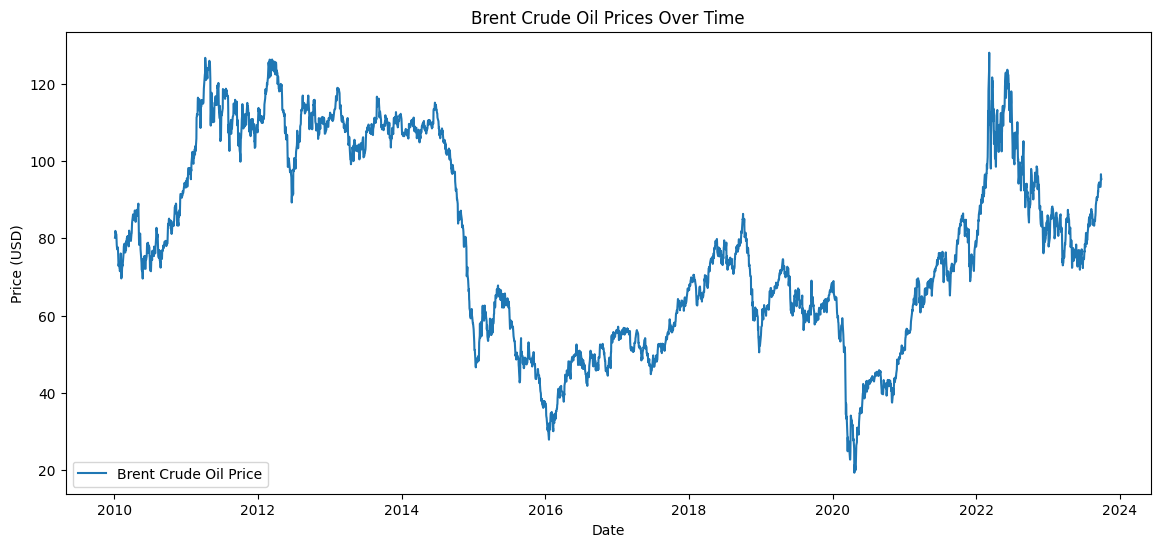

In [5]:
# Plot the time series
plt.figure(figsize=(14,6))
plt.plot(data['Date'], data['Oil_Price'], label='Brent Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Crude Oil Prices Over Time')
plt.legend()
plt.show()

# Explore the Data

In [6]:
# Augmented Dickey-Fuller Test for stationarity
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series)
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(data['Oil_Price'], 'Original Series')

Augmented Dickey-Fuller Test: Original Series
ADF Test Statistic: -1.6658970586847517
p-value: 0.44876340704218726
# Lags Used: 5
Number of Observations Used: 3419
=> The series is non-stationary.


In [7]:
# If non-stationary, take first difference
data['Oil_Price_diff'] = data['Oil_Price'].diff().dropna()
adf_test(data['Oil_Price_diff'].dropna(), 'First Difference')

Augmented Dickey-Fuller Test: First Difference
ADF Test Statistic: -27.051843947145464
p-value: 0.0
# Lags Used: 4
Number of Observations Used: 3419
=> The series is stationary.


<Figure size 1400x1000 with 0 Axes>

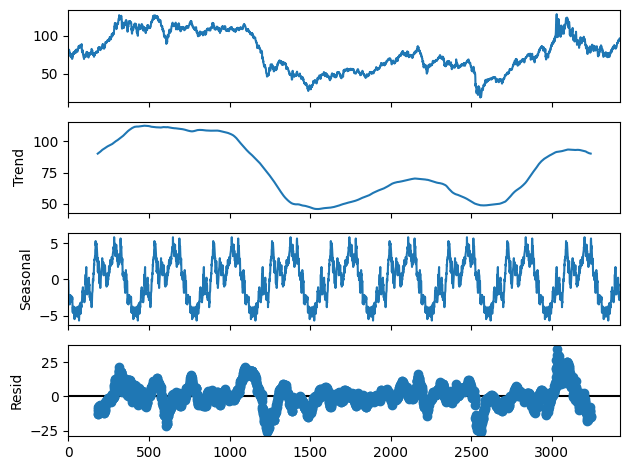

In [8]:
# Seasonal decomposition
decomposition = seasonal_decompose(data['Oil_Price'], model='additive', period=365)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

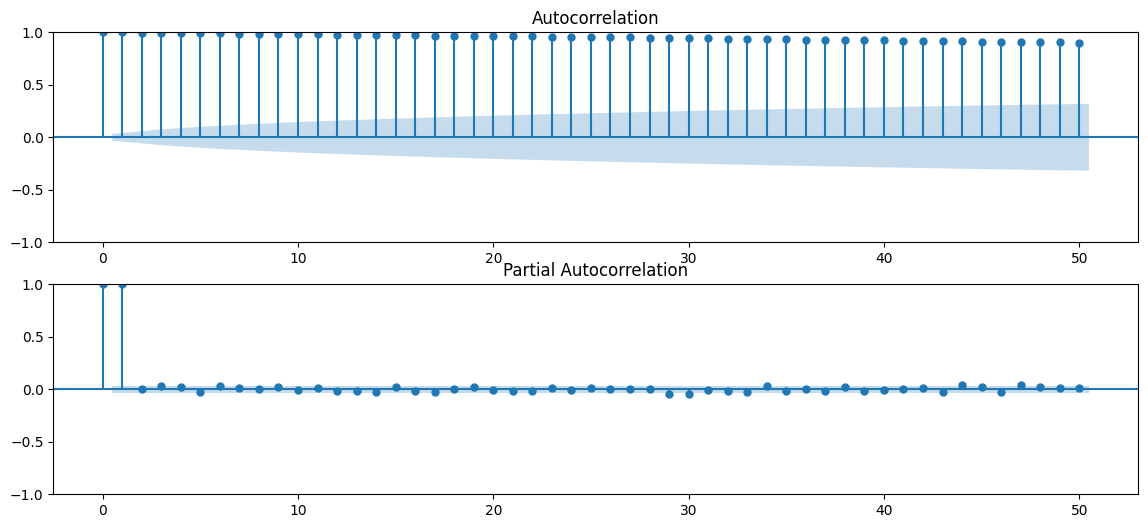

In [9]:
# Autocorrelation and partial autocorrelation
plt.figure(figsize=(14, 6))
plt.subplot(211)
plot_acf(data['Oil_Price'].dropna(), ax=plt.gca(), lags=50)
plt.subplot(212)
plot_pacf(data['Oil_Price'].dropna(), ax=plt.gca(), lags=50)
plt.show()

# Split the Data

In [10]:
# Sort data by date
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# Define train size (80%)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f'Training data points: {len(train)}')
print(f'Testing data points: {len(test)}')

Training data points: 2740
Testing data points: 685


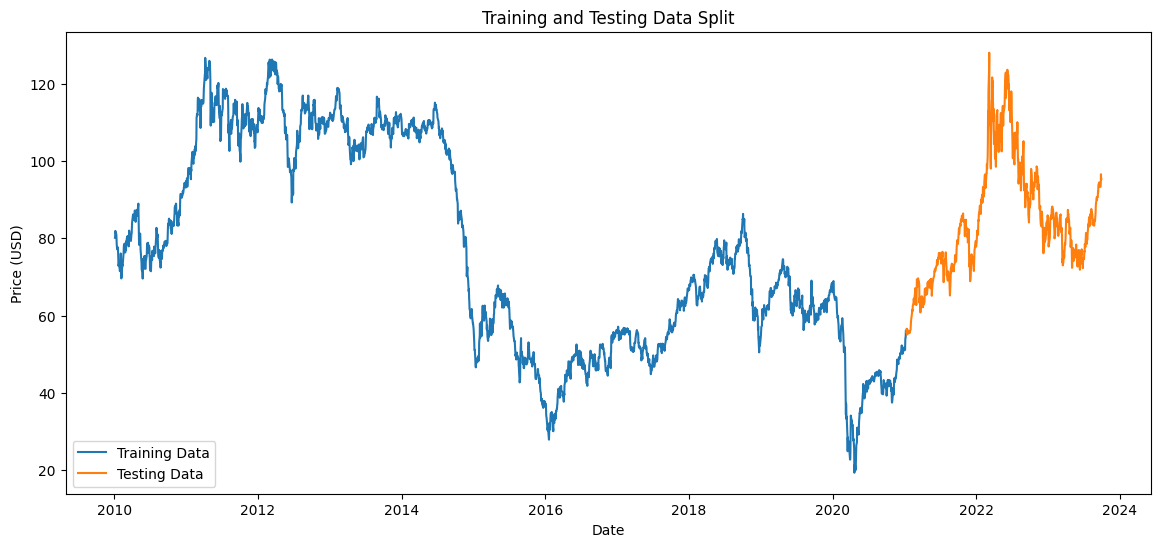

In [11]:
# Visualize the splits
plt.figure(figsize=(14,6))
plt.plot(train['Date'], train['Oil_Price'], label='Training Data')
plt.plot(test['Date'], test['Oil_Price'], label='Testing Data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Training and Testing Data Split')
plt.legend()
plt.show()

# Preprocess the Data

In [12]:
# Add time-based features
def add_time_features(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek
    return df

train = add_time_features(train)
test = add_time_features(test)

# Store test dates for plotting
test_dates = test['Date'].copy()

# Select features: target and time-related
features = ['Oil_Price', 'day', 'month', 'year', 'dayofweek']

# Ensure that only numeric features are selected
train = train[features].copy()
test = test[features].copy()

# Verify that all selected features are numeric
print("Data Types in Training Set:")
print(train.dtypes)
print("\nData Types in Testing Set:")
print(test.dtypes)

Data Types in Training Set:
Price      Ticker
Oil_Price  BZ=F      float64
day                    int32
month                  int32
year                   int32
dayofweek              int32
dtype: object

Data Types in Testing Set:
Price      Ticker
Oil_Price  BZ=F      float64
day                    int32
month                  int32
year                   int32
dayofweek              int32
dtype: object


In [13]:
# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Convert back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=features)
test_scaled = pd.DataFrame(test_scaled, columns=features)

# Verify scaled data
print("Scaled Training Data:")
print(train_scaled.head())

Scaled Training Data:
   Oil_Price       day  month  year  dayofweek
0   0.566437  0.100000    0.0   0.0       0.00
1   0.570816  0.133333    0.0   0.0       0.25
2   0.582930  0.166667    0.0   0.0       0.50
3   0.579389  0.200000    0.0   0.0       0.75
4   0.578084  0.233333    0.0   0.0       1.00


In [14]:
# Define sequence length N
N = 60  # Number of past time steps to use for prediction

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length=N):
        self.data = data.values  # Convert DataFrame to NumPy array
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length][0]  # Assuming 'Oil_Price' is the first column
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create datasets
train_dataset = TimeSeriesDataset(train_scaled)
test_dataset = TimeSeriesDataset(test_scaled)

In [15]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Verify shapes
for batch_X, batch_y in train_loader:
    print(f'Batch_X shape: {batch_X.shape}')  # Expected: [32, 60, 5]
    print(f'Batch_y shape: {batch_y.shape}')  # Expected: [32]
    break  # Only print for the first batch

Batch_X shape: torch.Size([32, 60, 5])
Batch_y shape: torch.Size([32])


# Define the Models

In [16]:
# SNN-LSTM Model
class SNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_steps=60, beta=0.95):
        super(SNNLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)

        # SNN parameters
        self.snntype = snn.Leaky(beta=beta)
        self.threshold = 1.0
        self.hidden_size = hidden_size
        self.num_steps = num_steps  # Number of simulation time steps

        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch, seq_len, hidden_size]
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step [batch, hidden_size]

        # Fully connected layer before SNN
        fc_out = self.fc1(lstm_out)  # [batch, hidden_size]

        # Initialize membrane potentials
        mem = torch.zeros_like(fc_out)

        # Simulate SNN over time steps
        spk_rec = []
        for step in range(self.num_steps):
            spk, mem = self.snntype(fc_out, mem)
            spk_rec.append(spk)

        # Sum spikes over time
        spk_sum = torch.stack(spk_rec, dim=0).sum(dim=0)

        # Final output layer
        out = self.fc2(spk_sum)
        return out

In [17]:
# Neural ODE LSTM Model
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, t, h):
        return self.linear(h)

class LSTMNeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMNeuralODE, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.ode_func = ODEFunc(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        c_0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        h_t = lstm_out[:, -1, :]  # Use last hidden state for ODE
        t = torch.linspace(0, 1, steps=10).to(x.device)  # Time steps for ODE solver
        h_t_ode = odeint(self.ode_func, h_t, t, method='rk4')[-1]  # Final ODE state
        output = self.fc(h_t_ode)
        return output

In [18]:
# ConvLSTM Model
class ConvLSTMHybrid(nn.Module):
    def __init__(self, input_channels, hidden_size, conv_out_channels, kernel_size, dilation_rate, lstm_hidden_size):
        super(ConvLSTMHybrid, self).__init__()

        # Convolutional layers
        self.temporal_conv = nn.Conv1d(in_channels=input_channels, out_channels=conv_out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.dilated_conv = nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=kernel_size, dilation=dilation_rate, padding=dilation_rate * (kernel_size - 1) // 2)

        # LSTM cell
        self.lstm_cell = nn.LSTMCell(input_size=conv_out_channels, hidden_size=lstm_hidden_size)

        # Output layer
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_channels]
        x = x.permute(0, 2, 1)  # Convert to [batch_size, input_channels, seq_len]
        x = self.temporal_conv(x)  # [batch_size, conv_out_channels, seq_len]
        x = self.dilated_conv(x)   # [batch_size, conv_out_channels, seq_len]
        x = x.permute(0, 2, 1)     # [batch_size, seq_len, conv_out_channels]

        # LSTM operations
        batch_size, seq_len, conv_out_channels = x.size()
        h_t = torch.zeros(batch_size, self.lstm_cell.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.lstm_cell.hidden_size).to(x.device)

        outputs = []
        for t_step in range(seq_len):
            h_t, c_t = self.lstm_cell(x[:, t_step, :], (h_t, c_t))
            outputs.append(h_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)  # [batch_size, seq_len, hidden_size]
        out = self.fc(outputs[:, -1, :])     # [batch_size, 1]

        return out

# Initialize the Models

In [19]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [20]:
# Define input size based on the number of features
input_size = 5  # ['Oil_Price', 'day', 'month', 'year', 'dayofweek']

In [21]:
# SNN-LSTM parameters
snn_hidden_size = 128
snn_output_size = 1
snn_num_layers = 2
snn_num_steps = 60  # Number of SNN simulation steps
snn_learning_rate = 0.001
snn_num_epochs = 100

snn_model = SNNLSTM(input_size, snn_hidden_size, snn_output_size, snn_num_layers, num_steps=snn_num_steps, beta=0.95).to(device)
snn_criterion = nn.MSELoss()
snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=snn_learning_rate)

In [22]:
# Neural ODE LSTM parameters
ode_hidden_dim = 50
ode_output_dim = 1
ode_num_layers = 1
ode_learning_rate = 0.001
ode_num_epochs = 100

ode_model = LSTMNeuralODE(input_size, ode_hidden_dim, ode_output_dim, num_layers=ode_num_layers).to(device)
ode_criterion = nn.MSELoss()
ode_optimizer = torch.optim.Adam(ode_model.parameters(), lr=ode_learning_rate)

In [23]:
# ConvLSTM parameters
conv_hidden_size = 50
conv_out_channels = 64
conv_kernel_size = 3
conv_dilation_rate = 2
conv_lstm_hidden_size = 50
conv_learning_rate = 0.001
conv_num_epochs = 100

conv_model = ConvLSTMHybrid(input_channels=input_size,  # Number of features as input channels
                           hidden_size=conv_hidden_size,
                           conv_out_channels=conv_out_channels,
                           kernel_size=conv_kernel_size,
                           dilation_rate=conv_dilation_rate,
                           lstm_hidden_size=conv_lstm_hidden_size).to(device)
conv_criterion = nn.MSELoss()
conv_optimizer = optim.Adam(conv_model.parameters(), lr=conv_learning_rate)

# Train the Models

In [24]:
# Function to train a model
def train_model(model, optimizer, criterion, dataloader, num_epochs, device, model_name='Model'):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)  # [batch_size, seq_len, num_features]
            batch_y = batch_y.to(device)  # [batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)  # [batch_size, 1]
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Loss: {avg_loss:.6f}')

In [25]:
# Training SNN-LSTM
print("Training SNN-LSTM Model")
train_model(
    model=snn_model,
    optimizer=snn_optimizer,
    criterion=snn_criterion,
    dataloader=train_loader,
    num_epochs=snn_num_epochs,
    device=device,
    model_name='SNN-LSTM'
)

Training SNN-LSTM Model
Epoch [1/100], SNN-LSTM Loss: 0.026419
Epoch [10/100], SNN-LSTM Loss: 0.001502
Epoch [20/100], SNN-LSTM Loss: 0.000865
Epoch [30/100], SNN-LSTM Loss: 0.000665
Epoch [40/100], SNN-LSTM Loss: 0.000564
Epoch [50/100], SNN-LSTM Loss: 0.000394
Epoch [60/100], SNN-LSTM Loss: 0.000319
Epoch [70/100], SNN-LSTM Loss: 0.000360
Epoch [80/100], SNN-LSTM Loss: 0.000370
Epoch [90/100], SNN-LSTM Loss: 0.000347
Epoch [100/100], SNN-LSTM Loss: 0.000270


In [26]:
# Training Neural ODE LSTM
print("Training Neural ODE LSTM Model")
train_model(
    model=ode_model,
    optimizer=ode_optimizer,
    criterion=ode_criterion,
    dataloader=train_loader,
    num_epochs=ode_num_epochs,
    device=device,
    model_name='Neural ODE LSTM'
)

Training Neural ODE LSTM Model
Epoch [1/100], Neural ODE LSTM Loss: 0.038052
Epoch [10/100], Neural ODE LSTM Loss: 0.000328
Epoch [20/100], Neural ODE LSTM Loss: 0.000258
Epoch [30/100], Neural ODE LSTM Loss: 0.000270
Epoch [40/100], Neural ODE LSTM Loss: 0.000259
Epoch [50/100], Neural ODE LSTM Loss: 0.000217
Epoch [60/100], Neural ODE LSTM Loss: 0.000236
Epoch [70/100], Neural ODE LSTM Loss: 0.000214
Epoch [80/100], Neural ODE LSTM Loss: 0.000193
Epoch [90/100], Neural ODE LSTM Loss: 0.000200
Epoch [100/100], Neural ODE LSTM Loss: 0.000190


In [27]:
# Training ConvLSTM
print("Training ConvLSTM Model")
train_model(
    model=conv_model,
    optimizer=conv_optimizer,
    criterion=conv_criterion,
    dataloader=train_loader,
    num_epochs=conv_num_epochs,
    device=device,
    model_name='ConvLSTM'
)

Training ConvLSTM Model
Epoch [1/100], ConvLSTM Loss: 0.016618
Epoch [10/100], ConvLSTM Loss: 0.000436
Epoch [20/100], ConvLSTM Loss: 0.000329
Epoch [30/100], ConvLSTM Loss: 0.000316
Epoch [40/100], ConvLSTM Loss: 0.000262
Epoch [50/100], ConvLSTM Loss: 0.000220
Epoch [60/100], ConvLSTM Loss: 0.000274
Epoch [70/100], ConvLSTM Loss: 0.000225
Epoch [80/100], ConvLSTM Loss: 0.000252
Epoch [90/100], ConvLSTM Loss: 0.000205
Epoch [100/100], ConvLSTM Loss: 0.000210


# Evaluate the Models

In [28]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)  # [1, 60, 5]
            batch_y = batch_y.to(device)  # [1]

            output = model(batch_X)  # [1, 1]

            predictions.append(output.cpu().item())
            actuals.append(batch_y.item())
    return predictions, actuals

# Get predictions
snn_preds, actuals_snn = get_predictions(snn_model, test_loader)
ode_preds, actuals_ode = get_predictions(ode_model, test_loader)
conv_preds, actuals_conv = get_predictions(conv_model, test_loader)

# Since actuals are the same across models, we can use one set
actuals = actuals_snn

In [29]:
# Extract the scaling parameters for 'Oil_Price'
oil_price_min = scaler.data_min_[0]
oil_price_max = scaler.data_max_[0]

def inverse_transform_oil_price(scaled_values):
    return scaled_values * (oil_price_max - oil_price_min) + oil_price_min

snn_preds_inverse = inverse_transform_oil_price(np.array(snn_preds))
ode_preds_inverse = inverse_transform_oil_price(np.array(ode_preds))
conv_preds_inverse = inverse_transform_oil_price(np.array(conv_preds))
actuals_inverse = inverse_transform_oil_price(np.array(actuals))

In [30]:
# Define evaluation metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    mae_train = mean_absolute_error(y_train[1:], y_train[:-1])
    return mae / mae_train

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [31]:
# Prepare training data for MASE
# Using only 'Oil_Price' from training data
y_train = train_scaled['Oil_Price'].values
mae_train = mean_absolute_error(y_train[1:], y_train[:-1])

# Compute metrics for each model
metrics = {}

In [32]:
# SNN-LSTM Metrics
mse_snn = mean_squared_error(actuals_inverse, snn_preds_inverse)
rmse_snn = np.sqrt(mse_snn)
mae_snn = mean_absolute_error(actuals_inverse, snn_preds_inverse)
mase_snn = mean_absolute_scaled_error(actuals_inverse, snn_preds_inverse, y_train)
mape_snn = np.mean(np.abs((actuals_inverse - snn_preds_inverse) / actuals_inverse)) * 100
smape_snn = symmetric_mean_absolute_percentage_error(actuals_inverse, snn_preds_inverse)

metrics['SNN-LSTM'] = [mse_snn, rmse_snn, mae_snn, mase_snn, mape_snn, smape_snn]

In [33]:
# Neural ODE LSTM Metrics
mse_ode = mean_squared_error(actuals_inverse, ode_preds_inverse)
rmse_ode = np.sqrt(mse_ode)
mae_ode = mean_absolute_error(actuals_inverse, ode_preds_inverse)
mase_ode = mean_absolute_scaled_error(actuals_inverse, ode_preds_inverse, y_train)
mape_ode = np.mean(np.abs((actuals_inverse - ode_preds_inverse) / actuals_inverse)) * 100
smape_ode = symmetric_mean_absolute_percentage_error(actuals_inverse, ode_preds_inverse)

metrics['Neural ODE LSTM'] = [mse_ode, rmse_ode, mae_ode, mase_ode, mape_ode, smape_ode]

In [34]:
# ConvLSTM Metrics
mse_conv = mean_squared_error(actuals_inverse, conv_preds_inverse)
rmse_conv = np.sqrt(mse_conv)
mae_conv = mean_absolute_error(actuals_inverse, conv_preds_inverse)
mase_conv = mean_absolute_scaled_error(actuals_inverse, conv_preds_inverse, y_train)
mape_conv = np.mean(np.abs((actuals_inverse - conv_preds_inverse) / actuals_inverse)) * 100
smape_conv = symmetric_mean_absolute_percentage_error(actuals_inverse, conv_preds_inverse)

metrics['ConvLSTM'] = [mse_conv, rmse_conv, mae_conv, mase_conv, mape_conv, smape_conv]

In [35]:
# Create dataframe for metrics
metrics_df = pd.DataFrame(metrics, index=['MSE', 'RMSE', 'MAE', 'MASE', 'MAPE', 'sMAPE']).T.round(3)
display(metrics_df)

,MSE,RMSE,MAE,MASE,MAPE,sMAPE
SNN-LSTM,6.744,2.597,1.957,212.060,2.229,2.244
Neural ODE LSTM,5.572,2.361,1.689,183.093,1.879,1.879
ConvLSTM,5.527,2.351,1.675,181.479,1.892,1.879


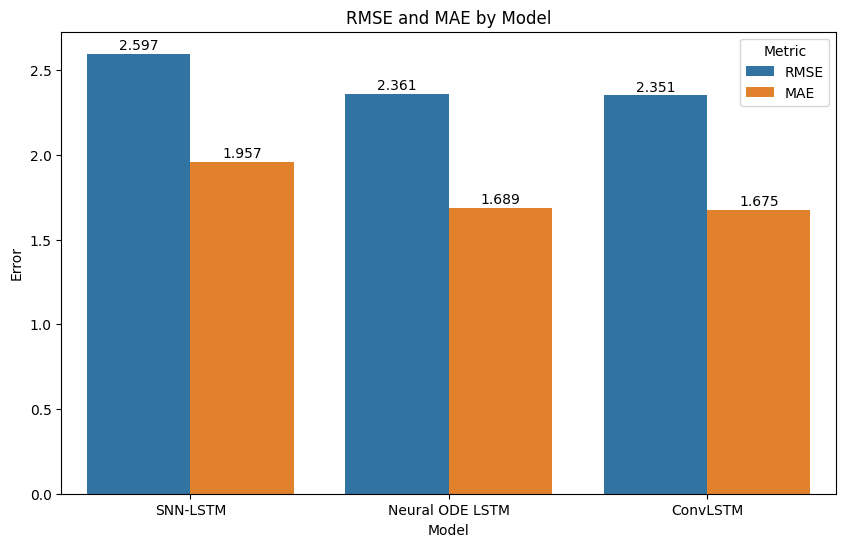

In [36]:
# Grouped bar chart for RMSE and MAE
plt.figure(figsize=(10, 6))
metrics_to_plot = metrics_df[['RMSE', 'MAE']].reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
sns.barplot(x='index', y='Value', hue='Metric', data=metrics_to_plot)
plt.title('RMSE and MAE by Model')
plt.xlabel('Model')
plt.ylabel('Error')

# Determine an appropriate offset
max_height = metrics_to_plot['Value'].max()
offset = max_height * 0.01  # 1% of the max height

# Annotate bars with values
for p in plt.gca().patches:
    if isinstance(p, matplotlib.patches.Rectangle) and p.get_height() > 0:
        height = p.get_height()
        plt.gca().text(p.get_x() + p.get_width()/2., height + offset, f'{height:.3f}', ha='center')

plt.show()

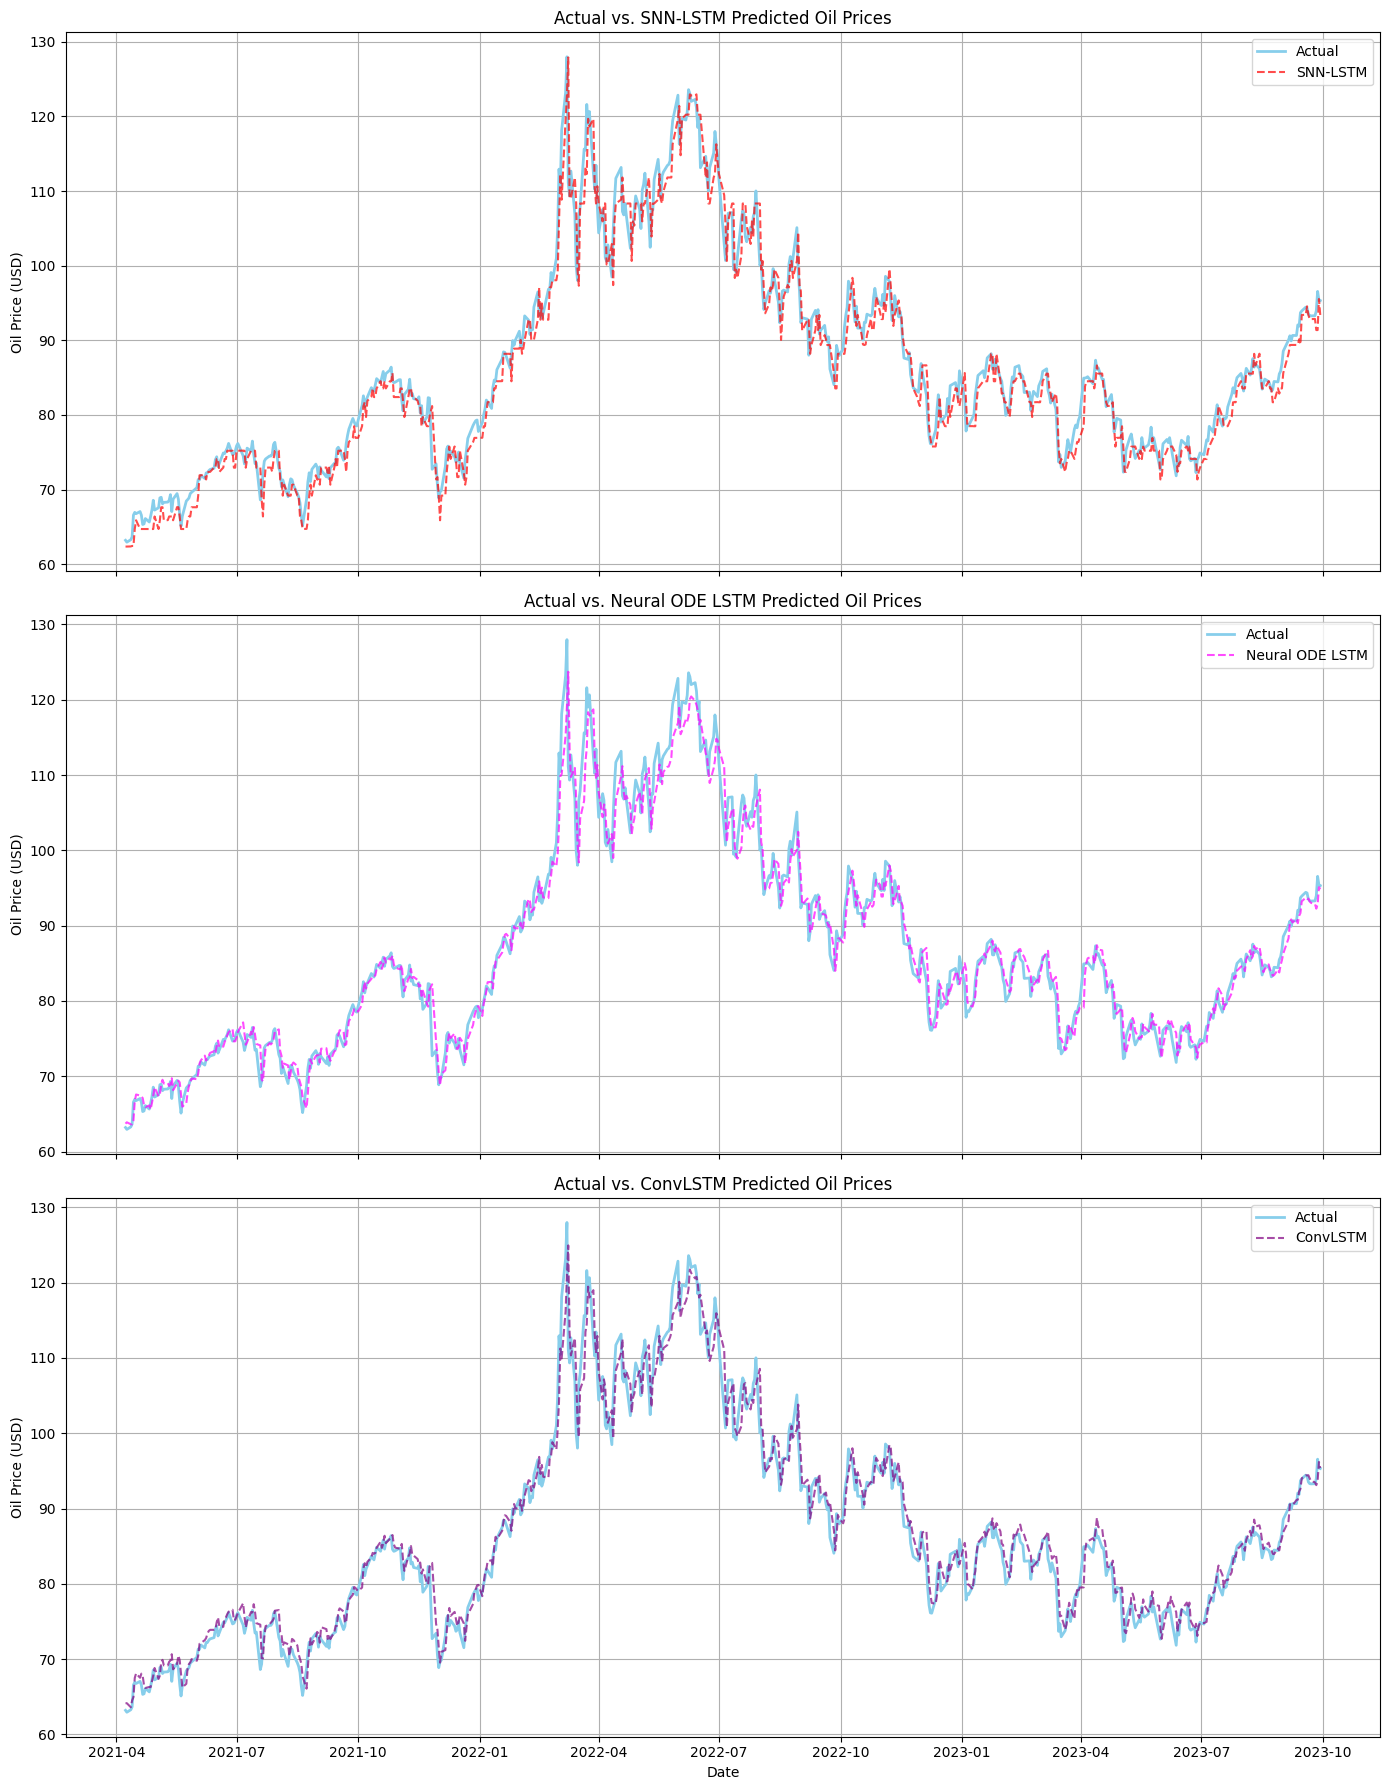

In [37]:
# Create a figure with subplots for each model vs. actual
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot Actual vs. SNN-LSTM
axes[0].plot(test_dates.iloc[N:].reset_index(drop=True), actuals_inverse, label='Actual', color='skyblue', linestyle='-', linewidth=2)
axes[0].plot(test_dates.iloc[N:].reset_index(drop=True), snn_preds_inverse, label='SNN-LSTM', linestyle='--', color='red', alpha=0.7)
axes[0].set_title('Actual vs. SNN-LSTM Predicted Oil Prices')
axes[0].set_ylabel('Oil Price (USD)')
axes[0].legend()
axes[0].grid(True)

# Plot Actual vs. Neural ODE LSTM
axes[1].plot(test_dates.iloc[N:].reset_index(drop=True), actuals_inverse, label='Actual', color='skyblue', linestyle='-', linewidth=2)
axes[1].plot(test_dates.iloc[N:].reset_index(drop=True), ode_preds_inverse, label='Neural ODE LSTM', linestyle='--', color='magenta', alpha=0.7)
axes[1].set_title('Actual vs. Neural ODE LSTM Predicted Oil Prices')
axes[1].set_ylabel('Oil Price (USD)')
axes[1].legend()
axes[1].grid(True)

# Plot Actual vs. ConvLSTM
axes[2].plot(test_dates.iloc[N:].reset_index(drop=True), actuals_inverse, label='Actual', color='skyblue', linestyle='-', linewidth=2)
axes[2].plot(test_dates.iloc[N:].reset_index(drop=True), conv_preds_inverse, label='ConvLSTM', linestyle='--', color='purple', alpha=0.7)
axes[2].set_title('Actual vs. ConvLSTM Predicted Oil Prices')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Oil Price (USD)')
axes[2].legend()
axes[2].grid(True)

# Show the plots
plt.tight_layout()
plt.show()